<a href="https://colab.research.google.com/github/claragwei/judge_judy/blob/main/scotus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oyez API

In [39]:
import requests
import json

# Base URL for the Oyez API
BASE_URL = "https://api.oyez.org/cases"
JUSTIA_BASE_URL = "https://supreme.justia.com/cases/federal/us"

# Function to get the case details (with Justia URL)
def get_case_details(term):
    # API endpoint to fetch cases for a specific term (per_page can be adjusted)
    url = f"{BASE_URL}?per_page=5&filter=term:{term}"

    try:
        # Send the request to the Oyez API
        response = requests.get(url)
        response.raise_for_status()  # Check if request was successful
        cases = response.json()  # Parse the JSON response

        # Process each case to extract the necessary details
        case_info = []
        for case in cases:
            docket_number = case.get("docket_number")
            justia_url = f"{JUSTIA_BASE_URL}/{docket_number[:3]}/{docket_number}"

            case_details = {
                "name": case.get("name"),
                "docket_number": docket_number,
                "case_url": f"{BASE_URL}/{term}/{docket_number}",
                "justia_opinion_url": justia_url,  # Construct Justia URL
                "oral_argument_audio": [],
                "full_case_data": case,  # Store full case data for debugging
            }

            # Extract the link to oral argument audio if available
            if 'oral_argument_audio' in case:
                for audio in case['oral_argument_audio']:
                    case_details['oral_argument_audio'].append({
                        "title": audio.get("title"),
                        "audio_url": audio.get("href")
                    })

            case_info.append(case_details)
        return case_info

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching case details: {e}")
        return []

# Function to inspect the full case data (debugging purposes)
def print_case_full_data(case_url):
    try:
        # Fetch the detailed case info
        response = requests.get(case_url)
        response.raise_for_status()
        case_data = response.json()

        # Print the entire response for inspection
        print(json.dumps(case_data, indent=2))  # This will show the full structure of the case data
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching the case data: {e}")

# Main function to fetch cases and their transcripts
def main():
    term = 2020  # Example term (change it to the desired term)

    print(f"Fetching cases for term {term}...\n")

    # Get the list of cases for the specified term
    case_details = get_case_details(term)

    if case_details:
        # Process each case and fetch its transcript or inspect full case data
        for case in case_details:
            print(f"\nProcessing Case: {case['name']} ({case['docket_number']})")
            print(f"Case URL: {case['case_url']}")
            print(f"Justia URL: {case['justia_opinion_url']}")  # Print Justia URL

            if case['oral_argument_audio']:
                for audio in case['oral_argument_audio']:
                    print(f"Fetching transcript for: {audio['title']}")
                    transcript = get_transcript_from_case(case['case_url'])

                    if transcript:
                        print(f"Transcript for {audio['title']}:")
                        for line in transcript:
                            print(f"{line['speaker']}: {line['text']}")
                    else:
                        print("No transcript found.")
            else:
                # Print full case data for inspection (debugging)
                print("No oral argument audio found. Inspecting full case data:")
                print_case_full_data(case['case_url'])

    else:
        print("No cases found for the specified term.")

# Run the main function
if __name__ == "__main__":
    main()


Fetching cases for term 2020...



MissingSchema: Invalid URL '2020': No scheme supplied. Perhaps you meant https://2020?

In [ ]:
import requests
import time

def get_case_data(case_url):
    try:
        response = requests.get(case_url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {case_url}: Status code {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching {case_url}: {e}")
        return None

def process_case(case):
    print(f"Processing Case: {case['name']}")
    print(f"Case URL: {case['href']}")

    data = get_case_data(case['href'])
    if not data:
        return

    # Extract Justia URL
    justia_url = data.get("justia_opinion_url", None)
    if justia_url:
        print(f"Justia URL: {justia_url}")
    else:
        print("No Justia URL found.")

    # Extract oral argument audio if available
    oral_arguments = data.get("oral_argument_audio", [])
    if oral_arguments:
        print(f"Oral Argument Audio URL: {oral_arguments[0]['href']}")
    else:
        print("No oral argument audio found.")

    print("-" * 40)

def process_all_cases():
    response = requests.get("https://api.oyez.org/cases/2020")
    if response.status_code != 200:
        print("Failed to fetch case list.")
        return

    case_list = response.json()
    for case in case_list:
        process_case(case)
        time.sleep(0.25)  # Be polite to the API

process_all_cases()


Processing Case: American Trucking Assns., Inc. v. United States
Case URL: https://api.oyez.org/cases/1966/510
No Justia URL found.
No oral argument audio found.
----------------------------------------
Processing Case: Gills v. California
Case URL: https://api.oyez.org/cases/1966/1043
No Justia URL found.
No oral argument audio found.
----------------------------------------
Processing Case: Central Bank & Trust Co. v. United States
Case URL: https://api.oyez.org/cases/1967/1269
No Justia URL found.
No oral argument audio found.
----------------------------------------
Processing Case: California v. Phillips Petroleum Co.
Case URL: https://api.oyez.org/cases/1967/373
No Justia URL found.
No oral argument audio found.
----------------------------------------
Processing Case: Boston & Maine R. Co. v. United States
Case URL: https://api.oyez.org/cases/1969/343
No Justia URL found.
No oral argument audio found.
----------------------------------------
Processing Case: Chicago v. United St

In [ ]:
def parse_case_data(case_json):
    data = {
        "name": case_json.get("name"),
        "docket_number": case_json.get("docket_number"),
        "decision_date": case_json.get("decision_date"),
        "first_party": case_json.get("first_party"),
        "second_party": case_json.get("second_party"),
        "justia_url": case_json.get("justia_url", None),
        "facts_of_the_case": case_json.get("facts_of_the_case"),
        "question": case_json.get("question"),
        "conclusion": case_json.get("conclusion"),
        "majority_opinion_by": None,
        "votes_majority": None,
        "votes_dissent": None,
        "oral_argument_audio": [],
        "transcript_text": ""
    }

    # Only parse oral argument audio if it's a list
    audio_list = case_json.get("oral_argument_audio")
    if isinstance(audio_list, list):
        for audio in audio_list:
            if audio.get("href"):
                data["oral_argument_audio"].append(audio["href"])

        # Also check for transcript if audio list exists
        for argument in audio_list:
            if "transcript" in argument and argument["transcript"]:
                try:
                    transcript_url = argument["transcript"]["url"]
                    resp = requests.get(transcript_url)
                    if resp.status_code == 200:
                        transcript_data = resp.json()
                        text = "\n".join([
                            f"{line['speaker']}: {line['text']}"
                            for line in transcript_data
                            if "speaker" in line and "text" in line
                        ])
                        data["transcript_text"] += text
                except Exception as e:
                    print(f"Error fetching transcript: {e}")

    # Parse majority opinion info
    for opinion in case_json.get("opinions", []):
        if opinion.get("majority", False):
            data["majority_opinion_by"] = opinion.get("author", {}).get("name")
            data["votes_majority"] = opinion.get("votes_majority")
            data["votes_dissent"] = opinion.get("votes_dissent")
            break

    return data


# TRY 2

Fetch Case Details from Oyez API: fetch case details, including oral argument audio links and the Justia opinion URL, for a specific term

Parse Full Case Data from Oyez: fetch the full details for each case using the Oyez API. This can include other case data like docket number, parties involved, etc.

Scrape Justia for Opinions: For cases with a valid Justia URL, scrapes the opinion text from the Justia page.

Extract and Process Transcripts (if available): extract and process the oral argument transcripts (if available), either from Oyez or Justia.



## dataframe attempt

In [ ]:
import requests
import json
import time
import os
import pandas as pd

# Base URLs
BASE_URL = "https://api.oyez.org/cases"
JUSTIA_BASE_URL = "https://supreme.justia.com/cases/federal/us"

# Ensure a directory for saving oral argument JSONs
os.makedirs("oral_arguments_json", exist_ok=True)

def get_case_details(term):
    url = f"{BASE_URL}?per_page=5&filter=term:{term}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        cases = response.json()

        case_info = []
        for case in cases:
            docket_number = case.get("docket_number")
            justia_url = f"{JUSTIA_BASE_URL}/{docket_number[:3]}/{docket_number}"

            case_details = {
                "name": case.get("name"),
                "docket_number": docket_number,
                "case_url": f"{BASE_URL}/{term}/{docket_number}",
                "justia_opinion_url": justia_url,
                "oral_argument_audio": [],
                "full_case_data": case,
            }

            case_info.append(case_details)
        return case_info

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching case details: {e}")
        return []

def get_case_data(case_url):
    try:
        response = requests.get(case_url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {case_url}: Status code {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching {case_url}: {e}")
        return None

def process_case(case, case_df):
    print(f"Processing Case: {case['name']}")
    print(f"Case URL: {case['case_url']}")
    print(f"Justia URL: {case['justia_opinion_url']}")

    case_data = get_case_data(case['case_url'])
    if not case_data:
        return case_df

    # Extract oral arguments
    oral_arguments = case_data.get("oral_argument_audio", [])
    audio_links = []
    if oral_arguments:
        for i, audio in enumerate(oral_arguments):
            audio_url = audio.get("href")
            if audio_url:
                audio_links.append(audio_url)
                try:
                    audio_response = requests.get(audio_url)
                    audio_response.raise_for_status()
                    audio_json = audio_response.json()

                    # Save JSON to file
                    filename = f"oral_arguments_json/{case['docket_number'].replace('/', '_')}_audio_{i+1}.json"
                    with open(filename, "w") as f:
                        json.dump(audio_json, f, indent=2)
                    print(f"Saved oral argument JSON to {filename}\n")
                except Exception as e:
                    print(f"Error fetching oral argument JSON from {audio_url}: {e}")
    else:
        print("No oral argument audio found.")

    # Extract structured data for the DataFrame
    case_row = pd.DataFrame([{
        "case_name": case["name"],
        "docket_number": case["docket_number"],
        "case_url": case["case_url"],
        "justia_url": case["justia_opinion_url"],
        "audio_links": ", ".join(audio_links) if audio_links else "N/A"
    }])

    case_df = pd.concat([case_df, case_row], ignore_index=True)
    print("-" * 60)
    return case_df

def main():
    term = 2020
    print(f"Fetching cases for term {term}...\n")
    case_details = get_case_details(term)

    # DataFrame to hold all processed case data
    case_df = pd.DataFrame(columns=["case_name", "docket_number", "case_url", "justia_url", "audio_links"])

    if case_details:
        for case in case_details:
            case_df = process_case(case, case_df)
            time.sleep(0.25)  # Be nice to the API
    else:
        print("No cases found for the specified term.")

    print("\nFinal DataFrame:")
    print(case_df)

    # Optionally save to CSV
    case_df.to_csv(f"cases_{term}.csv", index=False)
    return case_df

if __name__ == "__main__":
    main()


Fetching cases for term 2020...

Processing Case: Google LLC v. Oracle America Inc.
Case URL: https://api.oyez.org/cases/2020/18-956
Justia URL: https://supreme.justia.com/cases/federal/us/18-/18-956
Saved oral argument JSON to oral_arguments_json/18-956_audio_1.json

------------------------------------------------------------
Processing Case: United States v. Briggs
Case URL: https://api.oyez.org/cases/2020/19-108
Justia URL: https://supreme.justia.com/cases/federal/us/19-/19-108
Saved oral argument JSON to oral_arguments_json/19-108_audio_1.json

------------------------------------------------------------
Processing Case: Tanzin v. Tanvir
Case URL: https://api.oyez.org/cases/2020/19-71
Justia URL: https://supreme.justia.com/cases/federal/us/19-/19-71
Saved oral argument JSON to oral_arguments_json/19-71_audio_1.json

------------------------------------------------------------
Processing Case: Carney v. Adams
Case URL: https://api.oyez.org/cases/2020/19-309
Justia URL: https://supr

In [44]:
master_records = []
start_year = 2006
end_year = 2024  # You can update this dynamically if needed

for term in range(start_year, end_year + 1):
    print(f"\n=== Fetching cases for term {term} ===")
    case_details = get_case_details(term)

    for case in case_details:
        docket = case['docket_number'].replace('/', '_')
        case_name = case['name']
        topic = case.get('full_case_data', {}).get('issue', {}).get('title', "N/A")

        # Process and download JSON audio files
        process_case(case, pd.DataFrame())

        for i in range(1, 5):  # Up to 4 audio parts per case
            json_path = f"oral_arguments_json/{docket}_audio_{i}.json"
            if os.path.exists(json_path):
                records = extract_transcript_data(json_path, case_name, topic)
                master_records.extend(records)



=== Fetching cases for term 2006 ===


AttributeError: 'list' object has no attribute 'get'

# Final

In [43]:
import requests
import json
import time
import os

# Base URLs
BASE_URL = "https://api.oyez.org/cases"
JUSTIA_BASE_URL = "https://supreme.justia.com/cases/federal/us"

# Ensure a directory for saving oral argument JSONs
os.makedirs("oral_arguments_json", exist_ok=True)

import requests

import requests

def get_case_details(case_id):
    # Fetch the case data from the Oyez API
    url = f"https://api.oyez.org/cases/{case_id}"
    response = requests.get(url)

    if response.status_code != 200:
        return {"error": "Failed to fetch case data"}

    case_data = response.json()

    # Extract case name and docket number
    case_name = case_data.get("name", "Unknown")
    docket_number = case_data.get("docket", "Unknown")

    # Extract speaker, text, sentiment, and topic (if applicable)
    speaker = ""
    text = ""
    sentiment = 0  # Default value for sentiment, if not available in the response
    topic = "unknown"  # Default topic

    # Extract the opinions section
    opinions = case_data.get("opinions", [])
    votes = []  # List to store votes from the opinions
    justices = set()  # Set of justices who voted

    for opinion in opinions:
        for vote in opinion.get("votes", []):
            vote_type = vote.get('vote', '').lower()
            justice_name = vote.get('justice', {}).get('name', '').lower()

            # Collect votes and justices
            votes.append(vote_type)
            justices.add(justice_name)

    # Calculate majority and minority vote counts
    majority_vote = votes.count('majority')
    minority_vote = votes.count('dissenting')
    other_vote = len(votes) - (majority_vote + minority_vote)

    # Define ruling based on majority and minority vote counts
    if majority_vote == 0 and minority_vote == 0:
        ruling = "No decision available"
    elif majority_vote > minority_vote:
        ruling = f"Majority {majority_vote}-{minority_vote}"
    elif majority_vote == minority_vote:
        ruling = f"Split {majority_vote}-{minority_vote}"
    else:
        ruling = "Minority prevailed"

    # Check if Chief Justice Roberts was part of the ruling
    is_roberts = "john g. roberts, jr." in justices

    # Extract case URL and term
    case_url = case_data.get("url", "")
    term = case_data.get("term", "Unknown")

    # Get the topic and topic meta
    topic_meta = case_data.get("topic_meta", "unknown")

    # Prepare the result data
    result = {
        "case_name": case_name,
        "docket_number": docket_number,
        "speaker": speaker,
        "text": text,
        "sentiment": sentiment,
        "is_roberts": is_roberts,
        "topic": topic,
        "case_url": case_url,
        "term": term,
        "topic_meta": topic_meta,
        "ruling": ruling,
        "majority_vote": majority_vote,
        "minority_vote": minority_vote,
        "justices": list(justices),
        "audio_links": case_data.get("media", {}).get("oral_argument_audio", [])
    }

    return result


def get_case_data(case_url):
    try:
        response = requests.get(case_url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {case_url}: Status code {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching {case_url}: {e}")
        return None

def process_case(case):
    print(f"Processing Case: {case['name']}")
    print(f"Case URL: {case['case_url']}")
    print(f"Justia URL: {case['justia_opinion_url']}")

    case_data = get_case_data(case['case_url'])
    if not case_data:
        return

    oral_arguments = case_data.get("oral_argument_audio", [])
    if oral_arguments:
        for i, audio in enumerate(oral_arguments):
            audio_url = audio.get("href")
            if audio_url:
                try:
                    audio_response = requests.get(audio_url)
                    audio_response.raise_for_status()
                    audio_json = audio_response.json()

                    # Print the full JSON
                    print(json.dumps(audio_json, indent=2))

                    # Save to file
                    filename = f"oral_arguments_json/{case['docket_number'].replace('/', '_')}_audio_{i+1}.json"
                    with open(filename, "w") as f:
                        json.dump(audio_json, f, indent=2)

                    print(f"Saved oral argument JSON to {filename}\n")
                except Exception as e:
                    print(f"Error fetching oral argument JSON from {audio_url}: {e}")
    else:
        print("No oral argument audio found.")

    print("-" * 60)

def main():
    term = 2020
    print(f"Fetching cases for term {term}...\n")
    case_details = get_case_details(term)

    if case_details:
        for case in case_details:
            process_case(case)
            time.sleep(0.25)  # Be nice to the API
    else:
        print("No cases found for the specified term.")

if __name__ == "__main__":
    main()


Fetching cases for term 2020...



AttributeError: 'list' object has no attribute 'get'

# NLP Model

## preprocessing transcript with no speakers

In [ ]:
import json
import re

def preprocess_transcript(json_file_path):
    """
    Preprocess a Supreme Court oral argument transcript JSON file for NLP analysis.

    This function:
    1. Extracts only the spoken text from the transcript
    2. Removes periods and other punctuation
    3. Converts all text to lowercase
    4. Discards metadata and non-useful information

    Args:
        json_file_path (str): Path to the JSON file

    Returns:
        str: Preprocessed text as a single string
    """
    # Load the JSON data
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Extract only the transcript sections
    transcript_text = []

    # Navigate to the transcript sections
    if 'transcript' in data and 'sections' in data['transcript']:
        for section in data['transcript']['sections']:
            if 'turns' in section:
                for turn in section['turns']:
                    if 'text_blocks' in turn:
                        # Extract the actual spoken text from each text block
                        for text_block in turn['text_blocks']:
                            if 'text' in text_block:
                                transcript_text.append(text_block['text'])

    # Join all the text blocks into a single string
    full_text = ' '.join(transcript_text)

    # Remove punctuation (including periods)
    # We'll keep apostrophes to preserve contractions
    full_text = re.sub(r'[^\w\s\']', ' ', full_text)

    # Convert to lowercase
    full_text = full_text.lower()

    # Remove extra whitespace (multiple spaces, tabs, newlines)
    full_text = re.sub(r'\s+', ' ', full_text).strip()

    return full_text

# Example usage:
preprocessed_text = preprocess_transcript('/content/oral_arguments_json/18-956_audio_1.json')
print(preprocessed_text[:500])  # Print first 500 chars to check the output

we will hear argument first this morning in case 18 956 google versus oracle mr goldstein mr chief justice and may it please the court the merger doctrine resolved the copyrightability question in this case oracle has a copyright to the computer code in java se but not a patent that means that the public not oracle has the right to java se's function and oracle cannot leverage its copyright to create patent like rights specifically under the merger doctrine there is no copyright protection for c


## preprocessing with dictionary { speaker : text}

In [ ]:
import json
import re

def preprocess_transcript(json_file_path):
    """
    Preprocess a Supreme Court oral argument transcript JSON file for NLP analysis
    while always preserving speaker information.

    This function:
    1. Extracts the spoken text from the transcript
    2. Preserves speaker names
    3. Removes periods and other punctuation
    4. Converts all text to lowercase
    5. Discards metadata and non-useful information

    Args:
        json_file_path (str): Path to the JSON file

    Returns:
        list: List of dictionaries with 'speaker' and 'text' keys
    """
    # Load the JSON data
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Extract transcript with speaker information
    processed_turns = []

    # Navigate to the transcript sections
    if 'transcript' in data and 'sections' in data['transcript']:
        for section in data['transcript']['sections']:
            if 'turns' in section:
                for turn in section['turns']:
                    if 'speaker' in turn and 'text_blocks' in turn:
                        speaker_name = turn['speaker'].get('name', 'Unknown Speaker')

                        # Extract the actual spoken text from each text block
                        turn_text = []
                        for text_block in turn['text_blocks']:
                            if 'text' in text_block:
                                turn_text.append(text_block['text'])

                        # Join all text blocks for this turn
                        full_turn_text = ' '.join(turn_text)

                        # Remove punctuation (including periods)
                        # We'll keep apostrophes to preserve contractions
                        full_turn_text = re.sub(r'[^\w\s\']', ' ', full_turn_text)

                        # Convert to lowercase
                        full_turn_text = full_turn_text.lower()

                        # Remove extra whitespace
                        full_turn_text = re.sub(r'\s+', ' ', full_turn_text).strip()

                        # Add to our processed turns
                        processed_turns.append({
                            'speaker': speaker_name,
                            'text': full_turn_text
                        })

    return processed_turns

In [ ]:
# Example usage:
processed_transcript = preprocess_transcript('/content/oral_arguments_json/18-956_audio_1.json')

processed_transcript

[{'speaker': 'John G. Roberts, Jr.',
  'text': 'we will hear argument first this morning in case 18 956 google versus oracle mr goldstein'},
 {'speaker': 'Thomas C. Goldstein',
  'text': "mr chief justice and may it please the court the merger doctrine resolved the copyrightability question in this case oracle has a copyright to the computer code in java se but not a patent that means that the public not oracle has the right to java se's function and oracle cannot leverage its copyright to create patent like rights specifically under the merger doctrine there is no copyright protection for computer code that is the only way to perform those functions here java software developers have the right to use certain commands to create applications for google's android smartphone platform but to work the commands require google to reuse an exact set of declarations from java se like a key that fits into a lock because there are no substitutes oracle is impermissibly claiming the exclusive righ

In [ ]:
# Example usage 2:
processed_transcript = preprocess_transcript('/content/oral_arguments_json/19-108_audio_1.json')

processed_transcript

[{'speaker': 'John G. Roberts, Jr.',
  'text': 'we will hear argument first this morning in case 19 108 united states versus briggs and the consolidated case general wall'},
 {'speaker': 'Jeffrey B. Wall',
  'text': "mr chief justice and may it please the court when congress said in article 43 of the ucmj that an offense punishable by death may be prosecuted at any time congress was referring to the punishment it had provided for in the very same code respondents say that congress was up to something far more novel it was importing the eighth amendment's proportionality standard into the otherwise simple and predictable calculation of the time for bringing a prosecution in at least three ways the text says otherwise first the penalty and limitations provisions mirror each other article 120 says rape may be punished by death and article 43 then refers to offenses punishable by death congress naturally was referring in the limitations provision to the punishment it had fixed in the penal

## nlp model

In [ ]:
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Make sure required NLTK packages are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Load your preprocessed data
transcript = preprocess_transcript('/content/oral_arguments_json/18-956_audio_1.json')

# Convert to DataFrame for easier analysis
df = pd.DataFrame(transcript, columns=['speaker', 'text'])
df

,speaker,text
0,"John G. Roberts, Jr.",we will hear argument first this morning in ca...
1,Thomas C. Goldstein,mr chief justice and may it please the court t...
2,"John G. Roberts, Jr.",mr goldstein let's say someone copies the head...
3,Thomas C. Goldstein,no sir a computer program is entirely differen...
4,"John G. Roberts, Jr.",no i understand
...,...,...
222,Thomas C. Goldstein,sure so mr stewart's answer is effectively we ...
223,Brett M. Kavanaugh,all right thank you mr goldstein
224,"John G. Roberts, Jr.",mr goldstein you have got three minutes left i...
225,Thomas C. Goldstein,thank you mr chief justice i do want to focus ...


                      utterances  total_words  avg_words_per_utterance  \
speaker                                                                  
Thomas C. Goldstein           55         5456                99.200000   
E. Joshua Rosenkranz          20         2464               123.200000   
Malcolm L. Stewart            15         2222               148.133333   
Elena Kagan                   13          927                71.307692   
Stephen G. Breyer             11          913                83.000000   
John G. Roberts, Jr.          54          899                16.648148   
Neil Gorsuch                  14          657                46.928571   
Sonia Sotomayor               12          649                54.083333   
Brett M. Kavanaugh             9          470                52.222222   
Clarence Thomas               13          327                25.153846   
Samuel A. Alito, Jr.          11          317                28.818182   

                      max_words_per_u

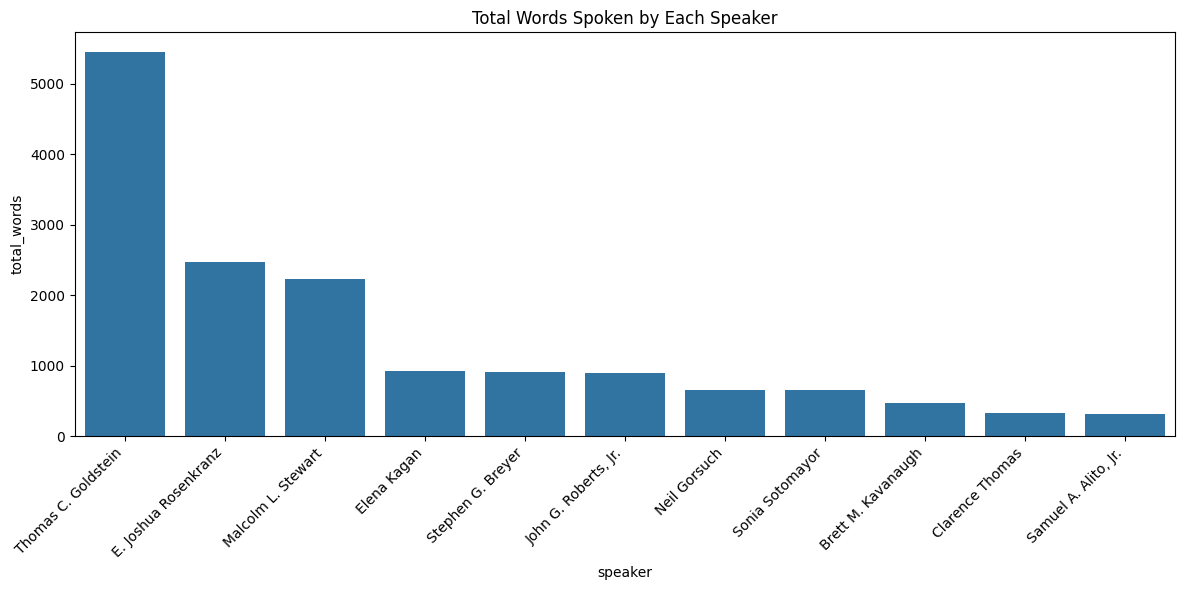

In [ ]:
# Word count analysis by speaker
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Summary statistics of speech by speaker
speaker_stats = df.groupby('speaker').agg(
    utterances=('text', 'count'),
    total_words=('word_count', 'sum'),
    avg_words_per_utterance=('word_count', 'mean'),
    max_words_per_utterance=('word_count', 'max')
).sort_values('total_words', ascending=False)

print(speaker_stats)

# Visualize speaking dominance
plt.figure(figsize=(12, 6))
sns.barplot(x=speaker_stats.index, y=speaker_stats['total_words'])
plt.xticks(rotation=45, ha='right')
plt.title('Total Words Spoken by Each Speaker')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate lexical diversity for each speaker
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if words else 0

# Combine all utterances by speaker
grouped_text = df.groupby('speaker')['text'].apply(' '.join).reset_index()
grouped_text['lexical_diversity'] = grouped_text['text'].apply(lexical_diversity)

# Get most common words by speaker
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def get_top_words(text, n=10):
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)

# Get top words for each speaker
grouped_text['top_words'] = grouped_text['text'].apply(get_top_words)

# Print lexical diversity and top words
for _, row in grouped_text.iterrows():
    print(f"Speaker: {row['speaker']}")
    print(f"Lexical Diversity: {row['lexical_diversity']:.4f}")
    print("Top 10 words:")
    for word, count in row['top_words']:
        print(f"  {word}: {count}")
    print()

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment for each utterance
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Average sentiment by speaker
sentiment_by_speaker = df.groupby('speaker')['sentiment'].mean().sort_values()

# Visualize sentiment
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_by_speaker.index, y=sentiment_by_speaker.values)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.title('Average Sentiment Score by Speaker')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Prepare corpus by combining all text from each speaker
corpus = grouped_text['text'].tolist()
speakers = grouped_text['speaker'].tolist()

# Create document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(corpus)

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Get top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print()

# Get topic distribution for each speaker
topic_distribution = lda.transform(doc_term_matrix)
for i, speaker in enumerate(speakers):
    print(f"Speaker: {speaker}")
    for topic_idx, weight in enumerate(topic_distribution[i]):
        print(f"  Topic #{topic_idx}: {weight:.4f}")
    print()

In [ ]:
# Simple question detection
df['is_question'] = df['text'].apply(lambda x: '?' in x or 'what' in x or 'how' in x or 'why' in x)

# Look at who asks and who answers questions
question_counts = df.groupby('speaker')['is_question'].sum().sort_values(ascending=False)
print("Number of questions by speaker:")
print(question_counts)

# Look at question-answer pairs
qa_pairs = []
for i in range(len(df) - 1):
    if df.iloc[i]['is_question']:
        qa_pairs.append({
            'questioner': df.iloc[i]['speaker'],
            'question': df.iloc[i]['text'],
            'responder': df.iloc[i+1]['speaker'],
            'response': df.iloc[i+1]['text']
        })

qa_df = pd.DataFrame(qa_pairs)
qa_interactions = qa_df.groupby(['questioner', 'responder']).size().unstack(fill_value=0)
print("\nQuestion-Answer Interaction Matrix:")
print(qa_interactions)

In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract entities
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply to each speaker's combined text
grouped_text['entities'] = grouped_text['text'].apply(extract_entities)

# Count entities by type for each speaker
entity_counts = {}
for _, row in grouped_text.iterrows():
    speaker = row['speaker']
    entity_types = [ent[1] for ent in row['entities']]
    entity_counts[speaker] = Counter(entity_types)

# Display entity types mentioned by each speaker
for speaker, counts in entity_counts.items():
    print(f"Speaker: {speaker}")
    for entity_type, count in counts.items():
        print(f"  {entity_type}: {count}")
    print()

In [ ]:
# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_text['text'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get most distinctive terms for each speaker
for i, speaker in enumerate(grouped_text['speaker']):
    print(f"Speaker: {speaker}")
    print("Most distinctive terms:")

    tfidf_scores = tfidf_matrix[i].toarray()[0]
    indices = tfidf_scores.argsort()[-10:][::-1]

    for idx in indices:
        print(f"  {feature_names[idx]}: {tfidf_scores[idx]:.4f}")
    print()

In [ ]:
# Create speaker profiles
speaker_profiles = pd.DataFrame()
speaker_profiles['speaker'] = grouped_text['speaker']
speaker_profiles['total_words'] = speaker_stats['total_words'].values
speaker_profiles['utterances'] = speaker_stats['utterances'].values
speaker_profiles['avg_words_per_utterance'] = speaker_stats['avg_words_per_utterance'].values
speaker_profiles['lexical_diversity'] = grouped_text['lexical_diversity'].values
speaker_profiles['avg_sentiment'] = df.groupby('speaker')['sentiment'].mean().values
speaker_profiles['questions_asked'] = question_counts.reindex(speaker_profiles['speaker']).values

# Display profiles
print(speaker_profiles)

# Visualize speaker profiles as radar charts
from math import pi

# Normalize values for radar chart
profile_data = speaker_profiles.set_index('speaker')
for column in profile_data.columns:
    profile_data[column] = (profile_data[column] - profile_data[column].min()) / (profile_data[column].max() - profile_data[column].min())

# Create radar chart for each speaker
categories = list(profile_data.columns)
N = len(categories)

# Set angle of each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for speaker in profile_data.index:
    values = profile_data.loc[speaker].values.flatten().tolist()
    values += values[:1]  # Close the loop

    ax.plot(angles, values, linewidth=1, label=speaker)
    ax.fill(angles, values, alpha=0.1)

# Set category labels
plt.xticks(angles[:-1], categories)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Speaker Profile Comparison')
plt.show()

## sentiment analysis + bias detection

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure necessary packages are downloaded
nltk.download('vader_lexicon')

# Load your preprocessed data
transcript = preprocess_transcript('/content/oral_arguments_json/18-956_audio_1.json')
df = pd.DataFrame(transcript, columns=['speaker', 'text'])

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment for each utterance
df['sentiment_scores'] = df['text'].apply(lambda x: sia.polarity_scores(x))
df['positive'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['neutral'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['negative'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# Aggregate sentiment by speaker
sentiment_by_speaker = df.groupby('speaker')[['positive', 'neutral', 'negative', 'compound']].mean()

print("Average sentiment by speaker:")
print(sentiment_by_speaker)

# Visualize compound sentiment by speaker
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_by_speaker.index, y=sentiment_by_speaker['compound'])
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.title('Average Sentiment Score by Speaker')
plt.ylabel('Compound Sentiment (Negative to Positive)')
plt.tight_layout()
plt.show()

# Analyze sentiment when discussing specific topics
def contains_topic(text, keywords):
    return any(keyword in text for keyword in keywords)

# Example: Analyze sentiment when discussing copyright
copyright_keywords = ['copyright', 'copyrightable', 'protection', 'license']
df['discussing_copyright'] = df['text'].apply(lambda x: contains_topic(x, copyright_keywords))

# Compare sentiment when discussing copyright vs. not
copyright_sentiment = df.groupby(['speaker', 'discussing_copyright'])['compound'].mean().unstack()
print("\nSentiment when discussing copyright vs. other topics:")
print(copyright_sentiment)

# Visualize the difference
copyright_sentiment.plot(kind='bar', figsize=(12, 6))
plt.title('Speaker Sentiment: Copyright Topics vs. Other Topics')
plt.ylabel('Compound Sentiment Score')
plt.tight_layout()
plt.show()

In [ ]:
# Track sentiment over time during the argument
df['utterance_number'] = range(len(df))
plt.figure(figsize=(14, 7))
plt.plot(df['utterance_number'], df['compound'], marker='o', alpha=0.5)
plt.title('Sentiment Flow Throughout the Arguments')
plt.xlabel('Utterance Sequence')
plt.ylabel('Compound Sentiment')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Rolling average to see sentiment trends
df['rolling_sentiment'] = df['compound'].rolling(window=5).mean()

# Sentiment when referring to different parties
def mentions_party(text, party_terms):
    return any(term in text for term in party_terms)

df['mentions_google'] = df['text'].apply(lambda x: mentions_party(x, ['google', 'android']))
df['mentions_oracle'] = df['text'].apply(lambda x: mentions_party(x, ['oracle', 'java', 'sun']))

# Compare sentiment when mentioning different parties
party_sentiment = df.groupby('speaker')[['mentions_google', 'mentions_oracle', 'compound']].apply(
    lambda x: pd.Series({
        'google_sentiment': x[x['mentions_google']]['compound'].mean(),
        'oracle_sentiment': x[x['mentions_oracle']]['compound'].mean(),
        'difference': x[x['mentions_google']]['compound'].mean() - x[x['mentions_oracle']]['compound'].mean()
    })
)

print("Sentiment difference when mentioning parties:")
print(party_sentiment)

In [ ]:
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 1. Analyze differential language use when referring to parties
def extract_context(text, target_term, window_size=5):
    words = text.split()
    contexts = []
    for i, word in enumerate(words):
        if target_term in word:
            start = max(0, i - window_size)
            end = min(len(words), i + window_size + 1)
            context = ' '.join(words[start:end])
            contexts.append(context)
    return contexts

# Extract contexts around party mentions
df['google_contexts'] = df['text'].apply(lambda x: extract_context(x, 'google'))
df['oracle_contexts'] = df['text'].apply(lambda x: extract_context(x, 'oracle'))

# Flatten contexts by speaker
google_contexts_by_speaker = {}
oracle_contexts_by_speaker = {}

for speaker in df['speaker'].unique():
    speaker_df = df[df['speaker'] == speaker]
    google_contexts = [context for contexts in speaker_df['google_contexts'] for context in contexts]
    oracle_contexts = [context for contexts in speaker_df['oracle_contexts'] for context in contexts]

    google_contexts_by_speaker[speaker] = ' '.join(google_contexts)
    oracle_contexts_by_speaker[speaker] = ' '.join(oracle_contexts)

# 2. Use TF-IDF to find distinctive terms used when discussing each party
speakers = sorted(google_contexts_by_speaker.keys())

# Prepare corpus - alternating Google and Oracle contexts for each speaker
corpus = []
corpus_labels = []
for speaker in speakers:
    if google_contexts_by_speaker[speaker]:
        corpus.append(google_contexts_by_speaker[speaker])
        corpus_labels.append(f"{speaker} - Google")
    if oracle_contexts_by_speaker[speaker]:
        corpus.append(oracle_contexts_by_speaker[speaker])
        corpus_labels.append(f"{speaker} - Oracle")

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
terms = tfidf_vectorizer.get_feature_names_out()

# Get distinctive terms used for each party by each speaker
for i, label in enumerate(corpus_labels):
    if i < len(tfidf_matrix.toarray()):
        print(f"\n{label} distinctive terms:")
        tfidf_scores = tfidf_matrix.toarray()[i]
        top_indices = tfidf_scores.argsort()[-10:][::-1]
        for idx in top_indices:
            if tfidf_scores[idx] > 0:
                print(f"  {terms[idx]}: {tfidf_scores[idx]:.4f}")

# 3. Analyze adjective and adverb usage - potential markers of bias
def extract_modifiers(text):
    doc = nlp(text)
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    adverbs = [token.text for token in doc if token.pos_ == 'ADV']
    return adjectives, adverbs

# Extract modifiers used with each party
party_modifiers = {}
for speaker in speakers:
    if google_contexts_by_speaker[speaker]:
        adj, adv = extract_modifiers(google_contexts_by_speaker[speaker])
        party_modifiers[f"{speaker} - Google"] = {'adjectives': Counter(adj), 'adverbs': Counter(adv)}

    if oracle_contexts_by_speaker[speaker]:
        adj, adv = extract_modifiers(oracle_contexts_by_speaker[speaker])
        party_modifiers[f"{speaker} - Oracle"] = {'adjectives': Counter(adj), 'adverbs': Counter(adv)}

# Display top modifiers for each party by speaker
for label, modifiers in party_modifiers.items():
    print(f"\n{label} top modifiers:")
    print("Adjectives:")
    for adj, count in modifiers['adjectives'].most_common(5):
        print(f"  {adj}: {count}")
    print("Adverbs:")
    for adv, count in modifiers['adverbs'].most_common(5):
        print(f"  {adv}: {count}")

# 4. Compare sentiment intensity when discussing each party
sentiment_bias = {}
for speaker in speakers:
    google_sentiment = sia.polarity_scores(google_contexts_by_speaker[speaker])['compound'] if google_contexts_by_speaker[speaker] else 0
    oracle_sentiment = sia.polarity_scores(oracle_contexts_by_speaker[speaker])['compound'] if oracle_contexts_by_speaker[speaker] else 0

    sentiment_bias[speaker] = {
        'google_sentiment': google_sentiment,
        'oracle_sentiment': oracle_sentiment,
        'bias_differential': google_sentiment - oracle_sentiment
    }

# Display sentiment bias
sentiment_bias_df = pd.DataFrame.from_dict(sentiment_bias, orient='index')
print("\nSentiment bias by speaker:")
print(sentiment_bias_df)

# Visualize sentiment bias
plt.figure(figsize=(12, 6))
sentiment_bias_df[['google_sentiment', 'oracle_sentiment']].plot(kind='bar', figsize=(12, 6))
plt.title('Sentiment Toward Parties by Speaker')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

# Visualize bias differential
plt.figure(figsize=(12, 6))
sentiment_bias_df['bias_differential'].plot(kind='bar', figsize=(12, 6))
plt.title('Sentiment Bias Differential by Speaker')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Google minus Oracle Sentiment (Positive = Google Bias)')
plt.tight_layout()
plt.show()

In [ ]:
# Create a bias profile for each speaker
bias_profiles = []

for speaker in speakers:
    speaker_df = df[df['speaker'] == speaker]

    # Basic metrics
    total_utterances = len(speaker_df)
    total_words = speaker_df['text'].apply(lambda x: len(x.split())).sum()

    # Entity mentions
    mentions_google = speaker_df['mentions_google'].sum()
    mentions_oracle = speaker_df['mentions_oracle'].sum()
    mention_ratio = mentions_google / mentions_oracle if mentions_oracle > 0 else float('inf')

    # Sentiment metrics
    overall_sentiment = speaker_df['compound'].mean()
    google_sentiment = speaker_df[speaker_df['mentions_google']]['compound'].mean() if any(speaker_df['mentions_google']) else 0
    oracle_sentiment = speaker_df[speaker_df['mentions_oracle']]['compound'].mean() if any(speaker_df['mentions_oracle']) else 0
    sentiment_differential = google_sentiment - oracle_sentiment

    # Question patterns
    questions_total = len(speaker_df[speaker_df['text'].str.contains('\\?')])
    questions_to_google = len(speaker_df[(speaker_df['text'].str.contains('\\?')) & (speaker_df['mentions_google'])])
    questions_to_oracle = len(speaker_df[(speaker_df['text'].str.contains('\\?')) & (speaker_df['mentions_oracle'])])
    question_ratio = questions_to_google / questions_to_oracle if questions_to_oracle > 0 else float('inf')

    # Interruption patterns (approximate)
    short_responses = len(speaker_df[speaker_df['text'].apply(lambda x: len(x.split())) < 10])

    # Compile profile
    profile = {
        'speaker': speaker,
        'total_utterances': total_utterances,
        'total_words': total_words,
        'mentions_google': mentions_google,
        'mentions_oracle': mentions_oracle,
        'mention_ratio': mention_ratio,
        'overall_sentiment': overall_sentiment,
        'google_sentiment': google_sentiment,
        'oracle_sentiment': oracle_sentiment,
        'sentiment_differential': sentiment_differential,
        'questions_total': questions_total,
        'questions_to_google': questions_to_google,
        'questions_to_oracle': questions_to_oracle,
        'question_ratio': question_ratio,
        'short_responses': short_responses
    }

    bias_profiles.append(profile)

# Convert to DataFrame for easier analysis
bias_profile_df = pd.DataFrame(bias_profiles)

print("Comprehensive bias profile:")
print(bias_profile_df[['speaker', 'mention_ratio', 'sentiment_differential', 'question_ratio']])

# Visualize potential bias indicators
plt.figure(figsize=(14, 8))

# Create a bias score (simple average of normalized metrics)
bias_profile_df['normalized_mention_ratio'] = (bias_profile_df['mention_ratio'] - bias_profile_df['mention_ratio'].mean()) / bias_profile_df['mention_ratio'].std() if bias_profile_df['mention_ratio'].std() > 0 else 0
bias_profile_df['normalized_sentiment_diff'] = (bias_profile_df['sentiment_differential'] - bias_profile_df['sentiment_differential'].mean()) / bias_profile_df['sentiment_differential'].std() if bias_profile_df['sentiment_differential'].std() > 0 else 0
bias_profile_df['normalized_question_ratio'] = (bias_profile_df['question_ratio'] - bias_profile_df['question_ratio'].mean()) / bias_profile_df['question_ratio'].std() if bias_profile_df['question_ratio'].std() > 0 else 0

# Combine metrics (positive = Google bias, negative = Oracle bias)
bias_profile_df['bias_score'] = (
    bias_profile_df['normalized_mention_ratio'] +
    bias_profile_df['normalized_sentiment_diff'] +
    bias_profile_df['normalized_question_ratio']
) / 3

# Plot the bias score
plt.figure(figsize=(12, 6))
sns.barplot(x='speaker', y='bias_score', data=bias_profile_df)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Overall Bias Assessment by Speaker')
plt.ylabel('Bias Score (Positive = Google Bias, Negative = Oracle Bias)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## reusable code

In [31]:
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure necessary packages are downloaded
def download_nltk_resources():
    """Download required NLTK resources."""
    resources = ['punkt', 'stopwords', 'wordnet', 'vader_lexicon']
    for resource in resources:
        try:
            nltk.download(resource, quiet=True)
        except Exception as e:
            print(f"Failed to download {resource}: {e}")


def load_transcript_to_dataframe(json_file_path):
    """
    Load and convert preprocessed transcript to a pandas DataFrame.

    Args:
        json_file_path (str): Path to the JSON transcript file

    Returns:
        pd.DataFrame: DataFrame with speaker and text columns
    """
    transcript = preprocess_transcript(json_file_path)
    df = pd.DataFrame(transcript, columns=['speaker', 'text'])
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    return df


def analyze_basic_speech_patterns(df):
    """
    Analyze basic speech patterns by speaker.

    Args:
        df (pd.DataFrame): DataFrame with 'speaker', 'text', and 'word_count' columns

    Returns:
        pd.DataFrame: DataFrame with speech statistics by speaker
    """
    speaker_stats = df.groupby('speaker').agg(
        utterances=('text', 'count'),
        total_words=('word_count', 'sum'),
        avg_words_per_utterance=('word_count', 'mean'),
        max_words_per_utterance=('word_count', 'max')
    ).sort_values('total_words', ascending=False)

    return speaker_stats


def plot_speaker_word_counts(speaker_stats):
    """
    Create a bar plot of total words spoken by each speaker.

    Args:
        speaker_stats (pd.DataFrame): DataFrame with speech statistics by speaker
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(x=speaker_stats.index, y=speaker_stats['total_words'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Total Words Spoken by Each Speaker')
    plt.tight_layout()
    plt.show()


def calculate_lexical_diversity(text):
    """
    Calculate lexical diversity (unique words / total words).

    Args:
        text (str): Text to analyze

    Returns:
        float: Lexical diversity score between 0 and 1
    """
    words = text.split()
    return len(set(words)) / len(words) if words else 0


def get_top_words(text, n=10, stop_words=None):
    """
    Get most frequently used words in text.

    Args:
        text (str): Text to analyze
        n (int): Number of top words to return
        stop_words (set): Set of stopwords to exclude

    Returns:
        list: List of (word, count) tuples
    """
    if stop_words is None:
        stop_words = set(nltk.corpus.stopwords.words('english'))

    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)


def analyze_vocabulary(df):
    """
    Analyze vocabulary and lexical diversity by speaker.

    Args:
        df (pd.DataFrame): DataFrame with 'speaker' and 'text' columns

    Returns:
        pd.DataFrame: DataFrame with vocabulary analysis
    """
    # Combine all utterances by speaker
    grouped_text = df.groupby('speaker')['text'].apply(' '.join).reset_index()
    grouped_text['lexical_diversity'] = grouped_text['text'].apply(calculate_lexical_diversity)

    # Get stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Get top words for each speaker
    grouped_text['top_words'] = grouped_text['text'].apply(lambda x: get_top_words(x, n=10, stop_words=stop_words))

    return grouped_text


def print_vocabulary_analysis(vocabulary_df):
    """
    Print vocabulary analysis results.

    Args:
        vocabulary_df (pd.DataFrame): DataFrame with vocabulary analysis
    """
    for _, row in vocabulary_df.iterrows():
        print(f"Speaker: {row['speaker']}")
        print(f"Lexical Diversity: {row['lexical_diversity']:.4f}")
        print("Top 10 words:")
        for word, count in row['top_words']:
            print(f"  {word}: {count}")
        print()


def analyze_sentiment(df):
    """
    Analyze sentiment for each utterance and aggregate by speaker.

    Args:
        df (pd.DataFrame): DataFrame with 'speaker' and 'text' columns

    Returns:
        tuple: (DataFrame with sentiment scores, sentiment by speaker DataFrame)
    """
    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Calculate sentiment for each utterance
    df['sentiment_scores'] = df['text'].apply(lambda x: sia.polarity_scores(x))
    df['positive'] = df['sentiment_scores'].apply(lambda x: x['pos'])
    df['neutral'] = df['sentiment_scores'].apply(lambda x: x['neu'])
    df['negative'] = df['sentiment_scores'].apply(lambda x: x['neg'])
    df['compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

    # Aggregate by speaker
    sentiment_by_speaker = df.groupby('speaker')[['positive', 'neutral', 'negative', 'compound']].mean()

    return df, sentiment_by_speaker


def plot_sentiment_by_speaker(sentiment_by_speaker):
    """
    Create a bar plot of average sentiment by speaker.

    Args:
        sentiment_by_speaker (pd.DataFrame): DataFrame with sentiment by speaker
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(x=sentiment_by_speaker.index, y=sentiment_by_speaker['compound'])
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Sentiment Score by Speaker')
    plt.ylabel('Compound Sentiment (Negative to Positive)')
    plt.tight_layout()
    plt.show()


def contains_topic(text, keywords):
    """
    Check if text contains any of the given keywords.

    Args:
        text (str): Text to check
        keywords (list): List of keywords to look for

    Returns:
        bool: True if any keyword is found, False otherwise
    """
    return any(keyword in text for keyword in keywords)


def analyze_topic_sentiment(df, topic_name, keywords):
    """
    Analyze sentiment when discussing a specific topic.

    Args:
        df (pd.DataFrame): DataFrame with 'speaker', 'text', and sentiment columns
        topic_name (str): Name of the topic for column naming
        keywords (list): List of keywords related to the topic

    Returns:
        pd.DataFrame: DataFrame with sentiment comparison for the topic
    """
    topic_column = f'discussing_{topic_name}'
    df[topic_column] = df['text'].apply(lambda x: contains_topic(x, keywords))

    # Compare sentiment when discussing the topic vs. not
    topic_sentiment = df.groupby(['speaker', topic_column])['compound'].mean().unstack()

    return topic_sentiment


def plot_topic_sentiment(topic_sentiment, topic_name):
    """
    Create a bar plot comparing sentiment when discussing a topic vs. not.

    Args:
        topic_sentiment (pd.DataFrame): DataFrame with topic sentiment comparison
        topic_name (str): Name of the topic for plot title
    """
    topic_sentiment.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Speaker Sentiment: {topic_name.title()} Topics vs. Other Topics')
    plt.ylabel('Compound Sentiment Score')
    plt.tight_layout()
    plt.show()


def plot_sentiment_flow(df):
    """
    Plot sentiment flow throughout the conversation.

    Args:
        df (pd.DataFrame): DataFrame with 'compound' sentiment column
    """
    df['utterance_number'] = range(len(df))
    plt.figure(figsize=(14, 7))
    plt.plot(df['utterance_number'], df['compound'], marker='o', alpha=0.5)
    plt.title('Sentiment Flow Throughout the Arguments')
    plt.xlabel('Utterance Sequence')
    plt.ylabel('Compound Sentiment')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Add rolling average
    df['rolling_sentiment'] = df['compound'].rolling(window=5).mean()
    plt.figure(figsize=(14, 7))
    plt.plot(df['utterance_number'], df['rolling_sentiment'], linewidth=2)
    plt.title('Sentiment Flow (5-Utterance Rolling Average)')
    plt.xlabel('Utterance Sequence')
    plt.ylabel('Compound Sentiment')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()


def detect_party_mentions(df, parties_dict):
    """
    Detect mentions of different parties in the text.

    Args:
        df (pd.DataFrame): DataFrame with 'text' column
        parties_dict (dict): Dictionary mapping party names to keywords

    Returns:
        pd.DataFrame: DataFrame with added party mention columns
    """
    for party, terms in parties_dict.items():
        column_name = f'mentions_{party}'
        df[column_name] = df['text'].apply(lambda x: contains_topic(x, terms))

    return df


def analyze_party_sentiment(df, parties):
    """
    Analyze sentiment when mentioning different parties.

    Args:
        df (pd.DataFrame): DataFrame with party mention columns and 'compound' sentiment
        parties (list): List of party names

    Returns:
        pd.DataFrame: DataFrame with sentiment analysis by party
    """
    party_sentiment = df.groupby('speaker').apply(
        lambda x: pd.Series({
            f'{party}_sentiment': x[x[f'mentions_{party}']]['compound'].mean()
                                if any(x[f'mentions_{party}']) else np.nan
            for party in parties
        })
    )

    # Calculate sentiment differences between parties
    for i in range(len(parties)):
        for j in range(i+1, len(parties)):
            party1, party2 = parties[i], parties[j]
            diff_col = f'{party1}_vs_{party2}'
            party_sentiment[diff_col] = party_sentiment[f'{party1}_sentiment'] - party_sentiment[f'{party2}_sentiment']

    return party_sentiment


def extract_context(text, target_term, window_size=5):
    """
    Extract context around mentions of a target term.

    Args:
        text (str): Text to analyze
        target_term (str): Term to find contexts for
        window_size (int): Number of words before and after to include

    Returns:
        list: List of context strings
    """
    words = text.split()
    contexts = []
    for i, word in enumerate(words):
        if target_term in word:
            start = max(0, i - window_size)
            end = min(len(words), i + window_size + 1)
            context = ' '.join(words[start:end])
            contexts.append(context)
    return contexts


def extract_party_contexts(df, parties_dict):
    """
    Extract contexts around mentions of different parties.

    Args:
        df (pd.DataFrame): DataFrame with 'speaker' and 'text' columns
        parties_dict (dict): Dictionary mapping party names to keywords

    Returns:
        tuple: (DataFrame with context columns, contexts by speaker dict)
    """
    # Add context columns to DataFrame
    for party in parties_dict:
        for term in parties_dict[party]:
            context_col = f'{party}_{term}_contexts'
            df[context_col] = df['text'].apply(lambda x: extract_context(x, term))

    # Organize contexts by speaker and party
    contexts_by_speaker = defaultdict(lambda: defaultdict(list))

    for speaker in df['speaker'].unique():
        speaker_df = df[df['speaker'] == speaker]

        for party in parties_dict:
            party_contexts = []
            for term in parties_dict[party]:
                context_col = f'{party}_{term}_contexts'
                contexts = [context for contexts in speaker_df[context_col] for context in contexts]
                party_contexts.extend(contexts)

            contexts_by_speaker[speaker][party] = ' '.join(party_contexts)

    return df, contexts_by_speaker


def analyze_distinctive_terms(contexts_by_speaker, parties):
    """
    Use TF-IDF to find distinctive terms used when discussing each party.

    Args:
        contexts_by_speaker (dict): Dictionary mapping speakers to party contexts
        parties (list): List of party names

    Returns:
        dict: Dictionary mapping labels to distinctive terms
    """
    # Prepare corpus
    corpus = []
    corpus_labels = []
    for speaker in sorted(contexts_by_speaker.keys()):
        for party in parties:
            if contexts_by_speaker[speaker][party]:
                corpus.append(contexts_by_speaker[speaker][party])
                corpus_labels.append(f"{speaker} - {party}")

    # Create TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names_out()

    # Get distinctive terms
    distinctive_terms = {}
    for i, label in enumerate(corpus_labels):
        if i < len(tfidf_matrix.toarray()):
            tfidf_scores = tfidf_matrix.toarray()[i]
            top_indices = tfidf_scores.argsort()[-10:][::-1]

            distinctive_terms[label] = {
                terms[idx]: tfidf_scores[idx] for idx in top_indices if tfidf_scores[idx] > 0
            }

    return distinctive_terms


def extract_modifiers(text, nlp=None):
    """
    Extract adjectives and adverbs from text using spaCy.

    Args:
        text (str): Text to analyze
        nlp: Initialized spaCy model (optional)

    Returns:
        tuple: (list of adjectives, list of adverbs)
    """
    if nlp is None:
        try:
            nlp = spacy.load("en_core_web_sm")
        except:
            print("Please install spaCy and download the 'en_core_web_sm' model")
            return [], []

    doc = nlp(text)
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    adverbs = [token.text for token in doc if token.pos_ == 'ADV']
    return adjectives, adverbs


def analyze_party_modifiers(contexts_by_speaker, parties):
    """
    Analyze adjectives and adverbs used with each party.

    Args:
        contexts_by_speaker (dict): Dictionary mapping speakers to party contexts
        parties (list): List of party names

    Returns:
        dict: Dictionary mapping labels to modifier analysis
    """
    try:
        nlp = spacy.load("en_core_web_sm")
    except:
        print("Please install spaCy and download the 'en_core_web_sm' model")
        return {}

    party_modifiers = {}
    for speaker in sorted(contexts_by_speaker.keys()):
        for party in parties:
            if contexts_by_speaker[speaker][party]:
                adj, adv = extract_modifiers(contexts_by_speaker[speaker][party], nlp)
                party_modifiers[f"{speaker} - {party}"] = {
                    'adjectives': Counter(adj),
                    'adverbs': Counter(adv)
                }

    return party_modifiers


def calculate_sentiment_bias(contexts_by_speaker, parties):
    """
    Calculate sentiment bias when discussing different parties.

    Args:
        contexts_by_speaker (dict): Dictionary mapping speakers to party contexts
        parties (list): List of party names

    Returns:
        pd.DataFrame: DataFrame with sentiment bias metrics
    """
    sia = SentimentIntensityAnalyzer()

    sentiment_bias = {}
    for speaker in sorted(contexts_by_speaker.keys()):
        sentiment_bias[speaker] = {}

        # Calculate sentiment for each party
        for party in parties:
            context = contexts_by_speaker[speaker][party]
            sentiment = sia.polarity_scores(context)['compound'] if context else np.nan
            sentiment_bias[speaker][f'{party}_sentiment'] = sentiment

        # Calculate differentials
        for i in range(len(parties)):
            for j in range(i+1, len(parties)):
                party1, party2 = parties[i], parties[j]
                sent1 = sentiment_bias[speaker][f'{party1}_sentiment']
                sent2 = sentiment_bias[speaker][f'{party2}_sentiment']

                if not (np.isnan(sent1) or np.isnan(sent2)):
                    sentiment_bias[speaker][f'{party1}_vs_{party2}'] = sent1 - sent2
                else:
                    sentiment_bias[speaker][f'{party1}_vs_{party2}'] = np.nan

    return pd.DataFrame.from_dict(sentiment_bias, orient='index')


def plot_sentiment_bias(sentiment_bias_df, parties):
    """
    Create visualizations of sentiment bias.

    Args:
        sentiment_bias_df (pd.DataFrame): DataFrame with sentiment bias metrics
        parties (list): List of party names
    """
    # Plot sentiment toward each party
    sentiment_cols = [f'{party}_sentiment' for party in parties]
    plt.figure(figsize=(12, 6))
    sentiment_bias_df[sentiment_cols].plot(kind='bar', figsize=(12, 6))
    plt.title('Sentiment Toward Parties by Speaker')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.ylabel('Sentiment Score')
    plt.tight_layout()
    plt.show()

    # Plot differentials
    diff_cols = []
    for i in range(len(parties)):
        for j in range(i+1, len(parties)):
            diff_cols.append(f'{parties[i]}_vs_{parties[j]}')

    if diff_cols:
        plt.figure(figsize=(12, 6))
        sentiment_bias_df[diff_cols].plot(kind='bar', figsize=(12, 6))
        plt.title('Sentiment Bias Differential by Speaker')
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.ylabel(f'Differential Sentiment')
        plt.tight_layout()
        plt.show()


def analyze_question_patterns(df, parties_dict):
    """
    Analyze question patterns by speaker and toward different parties.

    Args:
        df (pd.DataFrame): DataFrame with 'speaker', 'text', and party mention columns
        parties_dict (dict): Dictionary mapping party names to keywords

    Returns:
        pd.DataFrame: DataFrame with question pattern analysis
    """
    # Identify questions
    df['is_question'] = df['text'].apply(lambda x:
        '?' in x or any(q in x for q in ['what', 'how', 'why', 'when', 'where', 'who', 'which']))

    question_patterns = []

    for speaker in df['speaker'].unique():
        speaker_df = df[df['speaker'] == speaker]

        patterns = {
            'speaker': speaker,
            'total_utterances': len(speaker_df),
            'questions_total': speaker_df['is_question'].sum(),
            'question_ratio': speaker_df['is_question'].mean()
        }

        # Questions to specific parties
        for party in parties_dict:
            party_questions = speaker_df[(speaker_df['is_question']) &
                                         (speaker_df[f'mentions_{party}'])].shape[0]
            patterns[f'questions_to_{party}'] = party_questions

        question_patterns.append(patterns)

    return pd.DataFrame(question_patterns)


def create_bias_profile(df, parties):
    """
    Create a comprehensive bias profile for each speaker.

    Args:
        df (pd.DataFrame): Processed DataFrame with all necessary columns
        parties (list): List of party names

    Returns:
        pd.DataFrame: DataFrame with bias profiles
    """
    bias_profiles = []

    for speaker in df['speaker'].unique():
        speaker_df = df[df['speaker'] == speaker]

        # Basic metrics
        total_utterances = len(speaker_df)
        total_words = speaker_df['word_count'].sum()

        # Entity mentions
        mention_data = {}
        for party in parties:
            mentions = speaker_df[f'mentions_{party}'].sum()
            mention_data[f'mentions_{party}'] = mentions

        # Calculate mention ratios
        for i in range(len(parties)):
            for j in range(i+1, len(parties)):
                party1, party2 = parties[i], parties[j]
                mentions1 = mention_data[f'mentions_{party1}']
                mentions2 = mention_data[f'mentions_{party2}']

                ratio_key = f'{party1}_{party2}_mention_ratio'
                mention_data[ratio_key] = mentions1 / mentions2 if mentions2 > 0 else float('inf')

        # Sentiment metrics
        sentiment_data = {}
        sentiment_data['overall_sentiment'] = speaker_df['compound'].mean()

        for party in parties:
            party_sentiment = speaker_df[speaker_df[f'mentions_{party}']]['compound'].mean() \
                              if any(speaker_df[f'mentions_{party}']) else np.nan
            sentiment_data[f'{party}_sentiment'] = party_sentiment

        # Calculate sentiment differentials
        for i in range(len(parties)):
            for j in range(i+1, len(parties)):
                party1, party2 = parties[i], parties[j]
                sent1 = sentiment_data[f'{party1}_sentiment']
                sent2 = sentiment_data[f'{party2}_sentiment']

                diff_key = f'{party1}_{party2}_sentiment_diff'
                if not (np.isnan(sent1) or np.isnan(sent2)):
                    sentiment_data[diff_key] = sent1 - sent2
                else:
                    sentiment_data[diff_key] = np.nan

        # Question patterns
        question_data = {}
        question_data['questions_total'] = len(speaker_df[speaker_df['is_question']])

        for party in parties:
            questions_to_party = len(speaker_df[(speaker_df['is_question']) &
                                               (speaker_df[f'mentions_{party}'])])
            question_data[f'questions_to_{party}'] = questions_to_party

        # Calculate question ratios
        for i in range(len(parties)):
            for j in range(i+1, len(parties)):
                party1, party2 = parties[i], parties[j]
                q1 = question_data[f'questions_to_{party1}']
                q2 = question_data[f'questions_to_{party2}']

                ratio_key = f'{party1}_{party2}_question_ratio'
                question_data[ratio_key] = q1 / q2 if q2 > 0 else float('inf')

        # Compile profile
        profile = {
            'speaker': speaker,
            'total_utterances': total_utterances,
            'total_words': total_words
        }
        profile.update(mention_data)
        profile.update(sentiment_data)
        profile.update(question_data)

        bias_profiles.append(profile)

    return pd.DataFrame(bias_profiles)


def calculate_bias_score(bias_profile_df, parties):
    """
    Calculate an overall bias score using normalized metrics.

    Args:
        bias_profile_df (pd.DataFrame): DataFrame with bias profiles
        parties (list): List of party names

    Returns:
        pd.DataFrame: DataFrame with added bias scores
    """
    # Create a copy to avoid modifying the original
    df = bias_profile_df.copy()

    # Define metrics to include in bias score
    if len(parties) >= 2:
        party1, party2 = parties[0], parties[1]

        metrics = [
            f'{party1}_{party2}_mention_ratio',
            f'{party1}_{party2}_sentiment_diff',
            f'{party1}_{party2}_question_ratio'
        ]

        # Normalize each metric
        for metric in metrics:
            if metric in df.columns:
                norm_col = f'normalized_{metric}'
                mean = df[metric].mean()
                std = df[metric].std()

                if std > 0:
                    df[norm_col] = (df[metric] - mean) / std
                else:
                    df[norm_col] = 0

        # Calculate bias score (average of normalized metrics)
        norm_metrics = [f'normalized_{m}' for m in metrics if f'normalized_{m}' in df.columns]

        if norm_metrics:
            df['bias_score'] = df[norm_metrics].mean(axis=1)

    return df


def plot_bias_score(bias_profile_df, parties):
    """
    Create a visualization of the overall bias score.

    Args:
        bias_profile_df (pd.DataFrame): DataFrame with bias scores
        parties (list): List of party names
    """
    if 'bias_score' in bias_profile_df.columns:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='speaker', y='bias_score', data=bias_profile_df)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

        if len(parties) >= 2:
            title = f'Overall Bias Assessment (Positive = {parties[0]} Bias, Negative = {parties[1]} Bias)'
        else:
            title = 'Overall Bias Assessment by Speaker'

        plt.title(title)
        plt.ylabel('Bias Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


def run_sentiment_and_bias_analysis(json_file_path, parties_dict):
    """
    Run a complete sentiment and bias analysis on a transcript.

    Args:
        json_file_path (str): Path to the JSON transcript file
        parties_dict (dict): Dictionary mapping party names to keywords

    Returns:
        tuple: (Various DataFrames with analysis results)
    """
    # Download resources
    download_nltk_resources()

    # Load transcript
    df = load_transcript_to_dataframe(json_file_path)

    # Basic speech analysis
    speaker_stats = analyze_basic_speech_patterns(df)
    print("Basic speech statistics:")
    print(speaker_stats)
    plot_speaker_word_counts(speaker_stats)

    # Vocabulary analysis
    vocabulary_df = analyze_vocabulary(df)
    print("\nVocabulary analysis:")
    print_vocabulary_analysis(vocabulary_df)

    # Sentiment analysis
    df, sentiment_by_speaker = analyze_sentiment(df)
    print("\nSentiment analysis:")
    print(sentiment_by_speaker)
    plot_sentiment_by_speaker(sentiment_by_speaker)

    # Topic-specific sentiment
    parties = list(parties_dict.keys())

    # Detect party mentions
    df = detect_party_mentions(df, parties_dict)

    # Extract party contexts
    df, contexts_by_speaker = extract_party_contexts(df, parties_dict)

    # Analyze distinctive terms
    distinctive_terms = analyze_distinctive_terms(contexts_by_speaker, parties)
    print("\nDistinctive terms when discussing different parties:")
    for label, terms in distinctive_terms.items():
        print(f"\n{label}:")
        for term, score in terms.items():
            print(f"  {term}: {score:.4f}")

    # Analyze modifiers
    party_modifiers = analyze_party_modifiers(contexts_by_speaker, parties)
    print("\nModifiers used with different parties:")
    for label, modifiers in party_modifiers.items():
        print(f"\n{label}:")
        print("Adjectives:")
        for adj, count in modifiers['adjectives'].most_common(5):
            print(f"  {adj}: {count}")
        print("Adverbs:")
        for adv, count in modifiers['adverbs'].most_common(5):
            print(f"  {adv}: {count}")

    # Calculate sentiment bias
    sentiment_bias_df = calculate_sentiment_bias(contexts_by_speaker, parties)
    print("\nSentiment bias analysis:")
    print(sentiment_bias_df)
    plot_sentiment_bias(sentiment_bias_df, parties)

    # Analyze question patterns
    question_df = analyze_question_patterns(df, parties_dict)
    print("\nQuestion pattern analysis:")
    print(question_df)

    # Create comprehensive bias profile
    bias_profile_df = create_bias_profile(df, parties)
    bias_profile_df = calculate_bias_score(bias_profile_df, parties)
    print("\nComprehensive bias profile:")
    print(bias_profile_df)
    plot_bias_score(bias_profile_df, parties)

    return df, speaker_stats, vocabulary_df, sentiment_by_speaker, sentiment_bias_df, bias_profile_df

In [ ]:
# Define the parties involved in the case
parties_dict = {
    'google': ['google', 'android'],
    'oracle': ['oracle', 'java', 'sun']
}

# Run the analysis
results = run_sentiment_and_bias_analysis('/content/oral_arguments_json/18-956_audio_1.json', parties_dict)

# Unpack results
processed_df, speaker_stats, vocabulary_df, sentiment_by_speaker, sentiment_bias_df, bias_profile_df = results

# Additional analysis can be performed on these DataFrames
# For example, to analyze sentiment flow over time:
plot_sentiment_flow(processed_df)

In [ ]:
def define_demographic_features():
    """
    Define standard demographic features to track across all cases.

    Returns:
        dict: Dictionary of demographic features and possible values
    """
    demographic_features = {
        'gender': ['male', 'female', 'non_binary', 'unknown'],
        'age_group': ['under_40', '40_to_60', 'over_60', 'unknown'],
        'race': ['white', 'black', 'hispanic', 'asian', 'native_american', 'other', 'unknown'],
        'geographical_background': ['northeast', 'south', 'midwest', 'west', 'non_us', 'unknown']
    }

    return demographic_features

# Updated / most recent version + neural net model building

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-30-dbc45479af27>:219: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  case_topics = transcript_df[unknown_mask].groupby('case_name').apply(assign_topic_by_text).reset_index()


Analysis complete. Data saved to 'processed_transcripts.csv'
Training neural network models...
Training LSTM model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 0.3048 - loss: 1.3743 - val_accuracy: 0.3333 - val_loss: 1.3447
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.3457 - loss: 1.3355 - val_accuracy: 0.3333 - val_loss: 1.3479
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.3871 - loss: 1.2816 - val_accuracy: 0.3333 - val_loss: 1.3279
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.5328 - loss: 1.1862 - val_accuracy: 0.4321 - val_loss: 1.2951
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.6467 - loss: 0.9759 - val_accuracy: 0.5185 - val_loss: 1.1712
Training Transformer model...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3453 - loss: 1.4133 - val_accuracy: 0.3333 - val_loss: 1.3426
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3415 - loss: 1.3143 - val_accuracy: 0.3333 - val_loss: 1.2978
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4099 - loss: 1.2239 - val_

Model training complete!


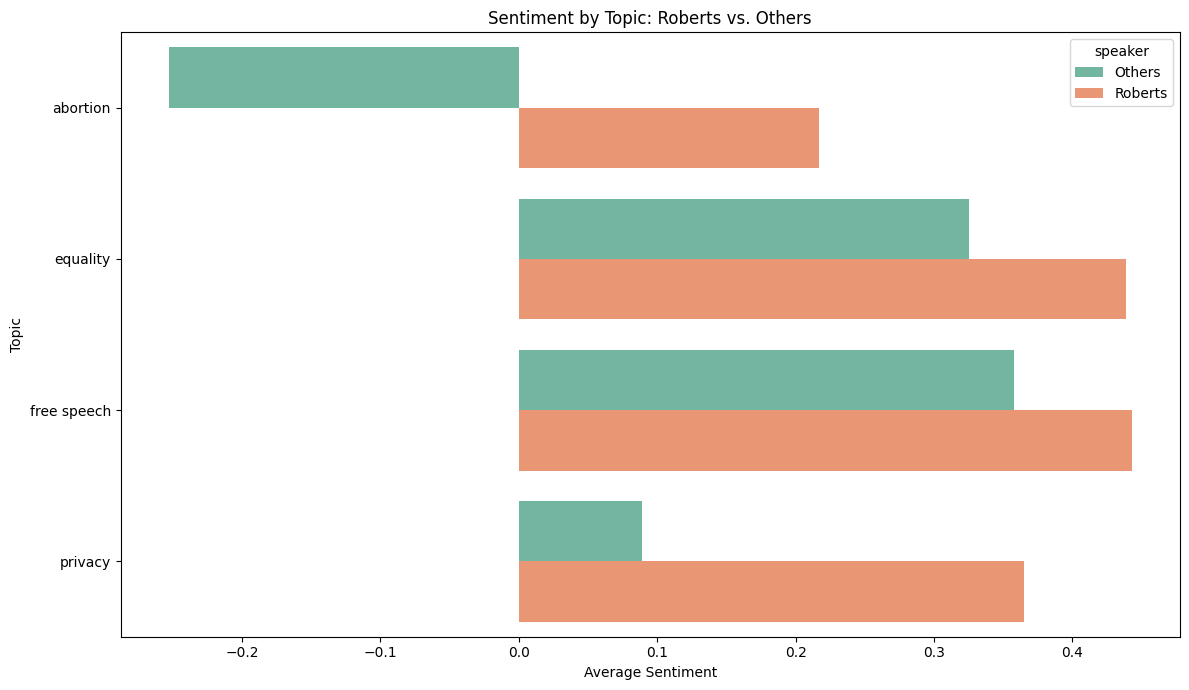

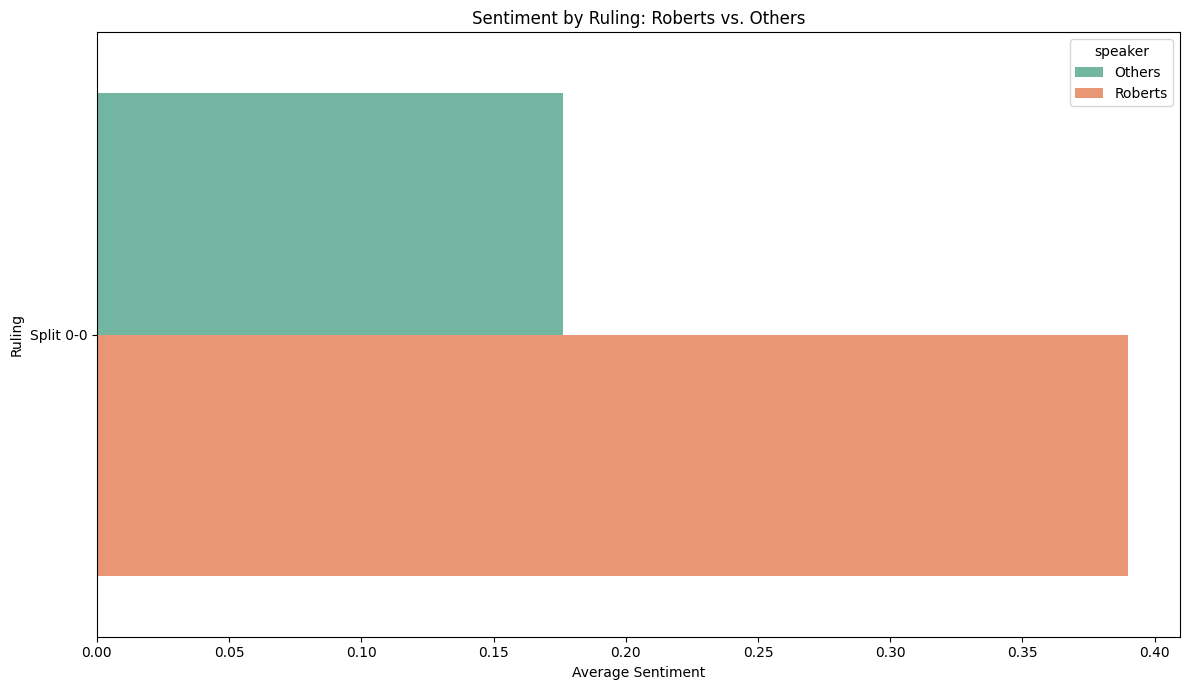

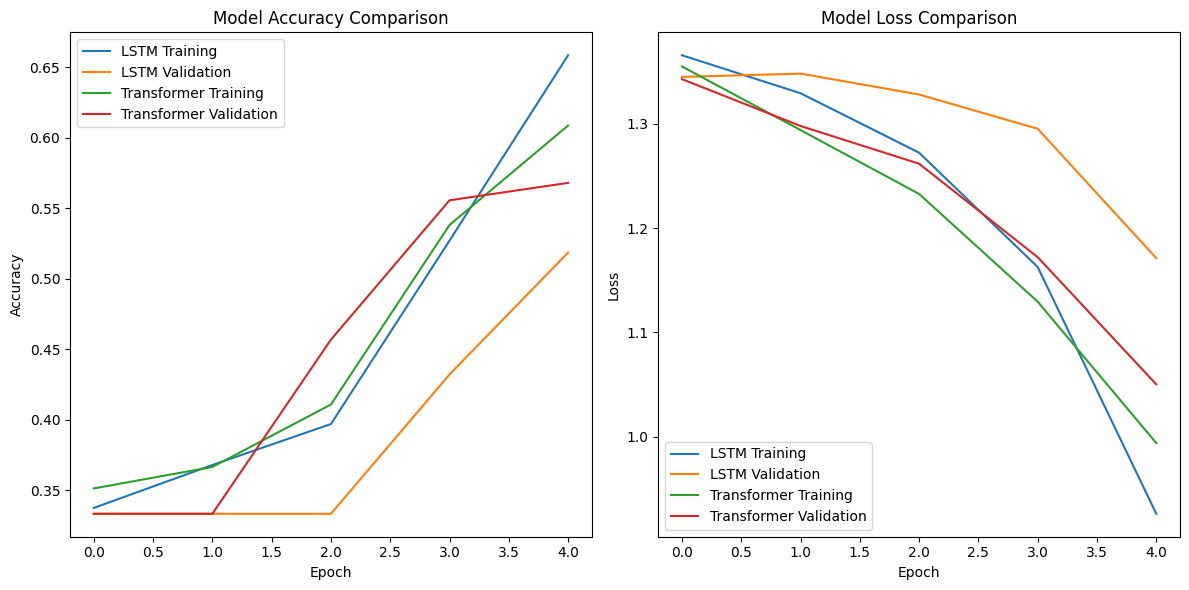

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re
import requests
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import nltk
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Input
import pickle

# Download required NLTK resources
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to extract transcript data from JSON files
def extract_transcript_data(json_path, case_name, case_metadata=None):
    with open(json_path, 'r') as f:
        data = json.load(f)

    records = []

    # Extract basic case metadata if available
    if case_metadata is None:
        case_metadata = {
            'topic': 'unknown',
            'justices': [],
            'ruling': 'unknown'
        }

    transcript = data.get('transcript')
    if transcript and isinstance(transcript, dict) and 'sections' in transcript:
        # Extract participating justices from the transcript
        participating_justices = set()

        for section in transcript.get('sections', []):
            for turn in section.get('turns', []):
                speaker_info = turn.get('speaker')
                if speaker_info and isinstance(speaker_info, dict):
                    speaker = speaker_info.get('name', 'unknown speaker')
                    speaker_role = speaker_info.get('role', '').lower()
                    speaker = speaker.lower()

                    # Add to list of participating justices if they're a justice
                    if 'justice' in speaker_role:
                        participating_justices.add(speaker)
                else:
                    speaker = 'unknown speaker'

                text_blocks = turn.get('text_blocks', [])
                combined_text = ' '.join(tb.get('text', '') for tb in text_blocks)

                # Clean and lowercase
                cleaned_text = re.sub(r"[^\w\s']", ' ', combined_text).lower()
                cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

                if cleaned_text:  # avoid empty strings
                    records.append({
                        'case_name': case_name.lower(),
                        'topic': case_metadata['topic'],
                        'speaker': speaker,
                        'text': cleaned_text,
                        'justices': ', '.join(case_metadata['justices']),
                        'participating_justices': ', '.join(participating_justices),
                        'ruling': case_metadata['ruling']
                    })
    return records

# Function to get case metadata from Oyez API
def get_case_metadata(docket_number, term):
    base_url = "https://api.oyez.org/cases"
    case_url = f"{base_url}/{term}/{docket_number}"

    try:
        response = requests.get(case_url)
        if response.status_code == 200:
            case_data = response.json()

            # Extract decision information
            decision = case_data.get('decision', {})
            majority_vote = decision.get('majority_vote', 0)
            minority_vote = decision.get('minority_vote', 0)

            # Determine ruling type
            if majority_vote > minority_vote:
                ruling = f"Majority {majority_vote}-{minority_vote}"
            elif majority_vote == minority_vote:
                ruling = f"Split {majority_vote}-{minority_vote}"
            else:
                ruling = "Unknown ruling"

            # Extract member votes to get list of justices
            member_votes = decision.get('votes', [])
            justices = [vote.get('member', {}).get('name', '').lower() for vote in member_votes if vote.get('member')]

            # Extract case topics/issues
            legal_topics = []
            for issue in case_data.get('issues', []):
                if issue.get('area'):
                    legal_topics.append(issue.get('area').lower())

            topic = ', '.join(legal_topics) if legal_topics else 'unknown'

            return {
                'topic': topic,
                'justices': justices,
                'ruling': ruling
            }
        else:
            print(f"Error fetching case metadata: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching case metadata: {e}")
        return None

# Load transcript data with case metadata
def load_transcript_data():
    all_records = []
    json_dir = "oral_arguments_json"

    if not os.path.exists(json_dir):
        print(f"Directory {json_dir} does not exist. Please run the data collection script first.")
        return pd.DataFrame()

    # Load cases CSV to get term information
    cases_df = None
    for year in range(2006, 2025):
        csv_path = f"cases_{year}.csv"
        if os.path.exists(csv_path):
            year_df = pd.read_csv(csv_path)
            cases_df = pd.concat([cases_df, year_df]) if cases_df is not None else year_df

    if cases_df is None:
        print("No cases CSV files found. Case metadata will be limited.")

    # Process each JSON file
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            # Extract case name and docket number from filename
            parts = filename.split('_audio_')
            if len(parts) < 2:
                continue

            docket_number = parts[0].replace('_', '/')
            case_name = None
            term = None

            # Try to find case info in the cases DataFrame
            if cases_df is not None:
                case_info = cases_df[cases_df['docket_number'] == docket_number]
                if not case_info.empty:
                    case_name = case_info.iloc[0]['case_name']
                    # Extract term from case_url
                    case_url = case_info.iloc[0]['case_url']
                    term_match = re.search(r'/cases/(\d+)/', case_url)
                    if term_match:
                        term = term_match.group(1)

            if case_name is None:
                case_name = docket_number

            # Get case metadata if term is available
            case_metadata = None
            if term is not None:
                case_metadata = get_case_metadata(docket_number, term)

            json_path = os.path.join(json_dir, filename)
            records = extract_transcript_data(json_path, case_name, case_metadata)
            all_records.extend(records)

    # Create DataFrame
    transcript_df = pd.DataFrame(all_records)
    return transcript_df

# Define topic keywords for fallback topic assignment
topic_keywords = {
    'free speech': ['speech', 'press', 'expression'],
    'equality': ['equal', 'discrimination', 'race'],
    'privacy': ['privacy', 'search', 'seizure'],
    'second amendment': ['gun', 'weapon', 'firearm'],
    'abortion': ['abortion', 'planned parenthood', 'choice'],
    'corporate law': ['corporation', 'business', 'stockholder']
}

# Improved topic assignment using text content (as fallback if no API topic)
def assign_topic_by_text(group):
    full_text = ' '.join(group['text'])
    words = full_text.lower().split()
    topic_scores = {
        topic: sum(words.count(word) for word in keywords)
        for topic, keywords in topic_keywords.items()
    }
    max_score = max(topic_scores.values()) if topic_scores else 0
    return max(topic_scores, key=topic_scores.get) if max_score > 0 else 'other'

def main():
    # Load transcript data with metadata
    transcript_df = load_transcript_data()

    if transcript_df.empty:
        print("No transcript data found.")
        return transcript_df

    # Fill in missing topics using the keyword-based approach
    if 'topic' in transcript_df.columns and transcript_df['topic'].eq('unknown').any():
        # Create a mask for rows with 'unknown' topic
        unknown_mask = transcript_df['topic'] == 'unknown'

        # Group those rows by case_name and assign topics
        case_topics = transcript_df[unknown_mask].groupby('case_name').apply(assign_topic_by_text).reset_index()
        case_topics.columns = ['case_name', 'assigned_topic']

        # Create a mapping dictionary
        topic_mapping = dict(zip(case_topics['case_name'], case_topics['assigned_topic']))

        # Apply the mapping only to rows with 'unknown' topic
        transcript_df.loc[unknown_mask, 'topic'] = transcript_df.loc[unknown_mask, 'case_name'].map(topic_mapping).fillna('other')

    # Add sentiment scores
    transcript_df['sentiment'] = transcript_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Normalize speaker names and identify Chief Justice Roberts
    transcript_df['speaker'] = transcript_df['speaker'].str.strip().str.lower()
    transcript_df['is_roberts'] = transcript_df['speaker'].str.contains('roberts')

    # Group and compare sentiment by topic and speaker
    comparison = transcript_df.groupby(['topic', 'is_roberts'])['sentiment'].mean().reset_index()
    comparison['speaker'] = comparison['is_roberts'].map({True: 'Roberts', False: 'Others'})

    # Visualization of sentiment by topic
    plt.figure(figsize=(12, 7))
    sns.barplot(data=comparison, x='sentiment', y='topic', hue='speaker', palette='Set2')
    plt.title('Sentiment by Topic: Roberts vs. Others')
    plt.xlabel('Average Sentiment')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.savefig('sentiment_by_topic.png')

    # Visualization of sentiment by ruling
    if 'ruling' in transcript_df.columns:
        ruling_sentiment = transcript_df.groupby(['ruling', 'is_roberts'])['sentiment'].mean().reset_index()
        ruling_sentiment['speaker'] = ruling_sentiment['is_roberts'].map({True: 'Roberts', False: 'Others'})

        plt.figure(figsize=(12, 7))
        sns.barplot(data=ruling_sentiment, x='sentiment', y='ruling', hue='speaker', palette='Set2')
        plt.title('Sentiment by Ruling: Roberts vs. Others')
        plt.xlabel('Average Sentiment')
        plt.ylabel('Ruling')
        plt.tight_layout()
        plt.savefig('sentiment_by_ruling.png')

    # Save the processed data
    transcript_df.to_csv('processed_transcripts.csv', index=False)

    print("Analysis complete. Data saved to 'processed_transcripts.csv'")
    return transcript_df

# Neural Network model for topic classification
def prepare_data_for_nn(transcript_df, max_words=10000, max_length=100):
    # Prepare the text data for neural network processing
    texts = transcript_df['text'].tolist()

    # Use topic as the label
    topics = transcript_df['topic'].tolist()

    # Create a mapping of unique topics to indices
    unique_topics = list(set(topics))
    topic_to_index = {topic: i for i, topic in enumerate(unique_topics)}

    # Convert topics to indices
    topic_indices = [topic_to_index[topic] for topic in topics]

    # Convert to one-hot encoding
    labels = pd.get_dummies(topic_indices).values

    # Tokenize the text
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to ensure uniform length
    data = pad_sequences(sequences, maxlen=max_length)

    return data, labels, tokenizer, unique_topics

def build_lstm_model(max_words=10000, embedding_dim=100, max_length=100, num_classes=7):
    # Build a simple LSTM model for topic classification
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_length))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

def train_neural_network(transcript_df):
    # Prepare data
    data, labels, tokenizer, unique_topics = prepare_data_for_nn(transcript_df)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Build and train model
    model = build_lstm_model(num_classes=labels.shape[1])
    history = model.fit(X_train, y_train,
                      epochs=10,
                      batch_size=32,
                      validation_split=0.1,
                      verbose=1)

    # Evaluate model
    score = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test accuracy: {score[1]:.4f}")

    # Save the model
    model.save('topic_classifier_lstm.h5')

    # Save the tokenizer and label mapping
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('topic_mapping.pickle', 'wb') as handle:
        pickle.dump(unique_topics, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model, history, tokenizer

# Custom Transformer block layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        # Fixed the training parameter by adding a default value
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build a transformer-based model
def build_transformer_model(max_words=10000, max_length=100, num_classes=7):
    # Define the model
    embedding_dim = 32  # Smaller for demo purposes
    num_heads = 2
    ff_dim = 32

    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length)(inputs)
    transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)(embedding_layer)

    x = GlobalAveragePooling1D()(transformer_block)
    x = Dropout(0.1)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# Function to train multiple models and compare
def train_multiple_models(transcript_df):
    # Prepare data
    data, labels, tokenizer, unique_topics = prepare_data_for_nn(transcript_df)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Dictionary to store results
    results = {}

    # Train LSTM model
    print("Training LSTM model...")
    lstm_model = build_lstm_model(num_classes=labels.shape[1])
    lstm_history = lstm_model.fit(
        X_train, y_train,
        epochs=5,  # Reduced for demonstration
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    lstm_score = lstm_model.evaluate(X_test, y_test, verbose=0)
    results['LSTM'] = {
        'accuracy': lstm_score[1],
        'history': lstm_history.history
    }

    # Train Transformer model
    print("Training Transformer model...")
    transformer_model = build_transformer_model(max_words=10000, max_length=data.shape[1], num_classes=labels.shape[1])
    transformer_history = transformer_model.fit(
        X_train, y_train,
        epochs=5,  # Reduced for demonstration
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    transformer_score = transformer_model.evaluate(X_test, y_test, verbose=0)
    results['Transformer'] = {
        'accuracy': transformer_score[1],
        'history': transformer_history.history
    }

    # Compare models
    print("\nModel Comparison:")
    for model_name, result in results.items():
        print(f"{model_name} Test Accuracy: {result['accuracy']:.4f}")

    # Plot comparison
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for model_name, result in results.items():
        plt.plot(result['history']['accuracy'], label=f"{model_name} Training")
        plt.plot(result['history']['val_accuracy'], label=f"{model_name} Validation")
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    for model_name, result in results.items():
        plt.plot(result['history']['loss'], label=f"{model_name} Training")
        plt.plot(result['history']['val_loss'], label=f"{model_name} Validation")
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_comparison.png')

    # Save models
    lstm_model.save('lstm_model.h5')
    transformer_model.save('transformer_model.h5')

    # Save topic mapping
    with open('topic_mapping.pickle', 'wb') as handle:
        pickle.dump(unique_topics, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return results

if __name__ == "__main__":
    transcript_df = main()

    # Train neural network if data is available
    if not transcript_df.empty and len(transcript_df) > 100:  # Ensure enough data
        print("Training neural network models...")

        # Option 1: Train a single LSTM model
        # model, history, tokenizer = train_neural_network(transcript_df)

        # Option 2: Train and compare multiple models
        model_results = train_multiple_models(transcript_df)

        print("Model training complete!")
    else:
        print("Not enough data to train a neural network model.")

# Updated 2

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import os
import re
import requests
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Function 1: Process transcript data only (without metadata)
def process_transcript_data():
    """
    Process transcript data from JSON files without additional metadata.
    Returns a DataFrame with basic transcript information.
    """
    all_records = []
    json_dir = "oral_arguments_json"

    if not os.path.exists(json_dir):
        print(f"Directory {json_dir} does not exist. Please run the data collection script first.")
        return pd.DataFrame()

    # Process each JSON file
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            # Extract case name and docket number from filename
            parts = filename.split('_audio_')
            if len(parts) < 2:
                continue

            docket_number = parts[0].replace('_', '/')
            case_name = docket_number  # Use docket number as fallback

            json_path = os.path.join(json_dir, filename)

            # Extract transcript data without additional metadata
            with open(json_path, 'r') as f:
                data = json.load(f)

            records = []
            transcript = data.get('transcript')
            if transcript and isinstance(transcript, dict) and 'sections' in transcript:
                for section in transcript.get('sections', []):
                    for turn in section.get('turns', []):
                        speaker_info = turn.get('speaker')
                        if speaker_info and isinstance(speaker_info, dict):
                            speaker = speaker_info.get('name', 'unknown speaker')
                        else:
                            speaker = 'unknown speaker'

                        speaker = speaker.lower()
                        text_blocks = turn.get('text_blocks', [])
                        combined_text = ' '.join(tb.get('text', '') for tb in text_blocks)

                        # Clean and lowercase
                        cleaned_text = re.sub(r"[^\w\s']", ' ', combined_text).lower()
                        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

                        if cleaned_text:  # avoid empty strings
                            records.append({
                                'case_name': case_name.lower(),
                                'docket_number': docket_number,
                                'speaker': speaker,
                                'text': cleaned_text
                            })

            all_records.extend(records)

    # Create DataFrame
    transcript_df = pd.DataFrame(all_records)

    # Add sentiment scores
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')

    sia = SentimentIntensityAnalyzer()
    transcript_df['sentiment'] = transcript_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Normalize speaker names and identify Chief Justice Roberts
    transcript_df['speaker'] = transcript_df['speaker'].str.strip().str.lower()
    transcript_df['is_roberts'] = transcript_df['speaker'].str.contains('roberts')

    # Add topic using keyword-based approach
    topic_keywords = {
        'free speech': ['speech', 'press', 'expression'],
        'equality': ['equal', 'discrimination', 'race'],
        'privacy': ['privacy', 'search', 'seizure'],
        'second amendment': ['gun', 'weapon', 'firearm'],
        'abortion': ['abortion', 'planned parenthood', 'choice'],
        'corporate law': ['corporation', 'business', 'stockholder']
    }

    # Function to assign topic based on text content
    def assign_topic_by_text(text):
        text_lower = text.lower()
        for topic, keywords in topic_keywords.items():
            if any(keyword in text_lower for keyword in keywords):
                return topic
        return 'other'

    # Apply topic assignment directly to each row
    transcript_df['topic'] = transcript_df['text'].apply(assign_topic_by_text)

    # Save the processed data
    transcript_df.to_csv('processed_transcripts.csv', index=False)

    print("Transcript processing complete. Data saved to 'processed_transcripts.csv'")
    return transcript_df

# Function 2: Create metadata CSV with case information, rulings, and justices
def create_case_metadata_csv():
    """
    Create a comprehensive CSV with case information, rulings, and justices.
    Returns a DataFrame with detailed case metadata.
    """
    # Base URLs
    BASE_URL = "https://api.oyez.org/cases"

    # Function to get case details for a specific term
def get_case_details(case_id):
    # Fetch the case data from the Oyez API
    url = f"https://api.oyez.org/cases/{case_id}"
    response = requests.get(url)

    if response.status_code != 200:
        return {"error": "Failed to fetch case data"}

    case_data = response.json()

    # Extract case name and docket number
    case_name = case_data.get("name", "Unknown")
    docket_number = case_data.get("docket", "Unknown")

    # Extract speaker, text, sentiment, and topic
    speaker = ""
    text = ""
    sentiment = 0
    topic = "unknown"

    # Handling opinions (Roberts' opinion, and others)
    opinions = case_data.get("opinions", [])
    votes = []
    for opinion in opinions:
        for vote in opinion.get("votes", []):
            votes.append(vote)  # Collect all votes

    # Determine the ruling (majority and minority vote counts)
    majority_vote = sum(1 for vote in votes if vote.get('vote', '').lower() == 'majority')
    minority_vote = sum(1 for vote in votes if vote.get('vote', '').lower() == 'dissenting')
    other_vote = sum(1 for vote in votes if vote.get('vote', '').lower() not in ['majority', 'dissenting'])

    if majority_vote == 0 and minority_vote == 0:
        ruling = "No decision available"
    elif majority_vote > minority_vote:
        ruling = f"Majority {majority_vote}-{minority_vote}"
    elif majority_vote == minority_vote:
        ruling = f"Split {majority_vote}-{minority_vote}"
    else:
        ruling = "Minority prevailed"

    # Justices who voted
    justices = [vote.get('justice', {}).get('name', '').lower() for vote in votes if vote.get('justice')]

    # Determine if Chief Justice Roberts was part of the ruling
    is_roberts = "john g. roberts, jr." in [justice.lower() for justice in justices]

    # Extract the case URL and term
    case_url = case_data.get("url", "")
    term = case_data.get("term", "Unknown")

    # Get the topic and meta-topic
    topic_meta = case_data.get("topic_meta", "unknown")

    # Prepare the result data
    result = {
        "case_name": case_name,
        "docket_number": docket_number,
        "speaker": speaker,
        "text": text,
        "sentiment": sentiment,
        "is_roberts": is_roberts,
        "topic": topic,
        "case_url": case_url,
        "term": term,
        "topic_meta": topic_meta,
        "ruling": ruling,
        "majority_vote": majority_vote,
        "minority_vote": minority_vote,
        "justices": justices,
        "audio_links": case_data.get("media", {}).get("oral_argument_audio", [])
    }

    return result

    # Function to get detailed case data
    def get_case_data(case_url):
        try:
            response = requests.get(case_url)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Error fetching {case_url}: Status code {response.status_code}")
                return None
        except Exception as e:
            print(f"Error fetching {case_url}: {e}")
            return None

    # Gather cases from multiple terms
    all_cases = []
    for term in range(2006, 2025):
        print(f"Fetching cases for term {term}...")
        case_details = get_case_details(term)
        all_cases.extend(case_details)
        time.sleep(0.25)  # Be nice to the API

    # Create DataFrame
    case_df = pd.DataFrame(all_cases)

    # Save to CSV
    case_df.to_csv('cases_with_metadata.csv', index=False)

    print("Case metadata processing complete. Data saved to 'cases_with_metadata.csv'")
    return case_df

# Function to merge transcript and metadata DataFrames
def merge_transcript_and_metadata():
    """
    Merge transcript data with case metadata.
    """
    # Load both DataFrames
    transcript_df = pd.read_csv('processed_transcripts.csv')
    case_metadata_df = pd.read_csv('cases_with_metadata.csv')

    # Merge on docket number
    merged_df = transcript_df.merge(
        case_metadata_df,
        on='docket_number',
        how='left',
        suffixes=('', '_meta')
    )

    # Clean up column names
    if 'case_name_meta' in merged_df.columns:
        merged_df.drop('case_name_meta', axis=1, inplace=True)

    # Save merged data
    merged_df.to_csv('merged_transcript_metadata.csv', index=False)
    print("Merged data saved to 'merged_transcript_metadata.csv'")
    return merged_df

# Example usage
if __name__ == "__main__":
    # For transcript processing only:
    transcript_df = process_transcript_data()

    # For detailed case metadata (uncomment if needed):
    case_metadata_df = create_case_metadata_csv()

    # For merging transcript and metadata (uncomment if needed):
    merged_df = merge_transcript_and_metadata()

Transcript processing complete. Data saved to 'processed_transcripts.csv'
Merged data saved to 'merged_transcript_metadata.csv'


## example usage

# neural networks